In [34]:
SCREEN = "20250216_AWALS37_Full_screen_n96"
ANALYSIS = "binary"

In [40]:
import json
import pickle

from pathlib import Path
from maps.screens import ImageScreenMultiAntibody

# --- Initialize parameters ---
pdir = Path("/home/kkumbier/als/scripts/pipelines/params")
with open(pdir / f"{ANALYSIS}.json", "r") as f:
    params = json.load(f)

params["screen"] = SCREEN

# initialize key mapping cell lines to mutations
screen = ImageScreenMultiAntibody(params)
plate_dirs = screen.loader._get_plate_dirs()
metadata = screen.loader.load_metadata(plate_dirs[0])
cellline_to_mutation = dict(zip(metadata["CellLines"], metadata["Mutations"]))

# load in analysis results
output_dir = Path(params.get("result_dir")) / params.get("screen")
files = list(output_dir.glob(f"{ANALYSIS}-*.pkl"))

files = [f for f in files if "488" in str(f) or "647" in str(f)]

results = []
for f in files:
    with open(f, "rb") as file:
        results.append(pickle.load(file)["analysis"])

In [41]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# Iterate over results and combine all predictions
df_list = []
for idx, result in enumerate(results):
    for model_genetics, val in result.fitted.items():
        df = val["predicted"].to_pandas()
        df["ModelGenetics"] = model_genetics
        df["Mutations"] = df["CellLines"].map(cellline_to_mutation)
        df["ResultIndex"] = idx
        df_list.append(df)

# Combine into single dataframe
all_predictions = pd.concat(df_list, ignore_index=True)

In [42]:
# Group by CellLines, ModelGenetics, ResultIndex, and Mutations
grouped_predictions = all_predictions.groupby(
    ["CellLines", "ModelGenetics", "ResultIndex", "Mutations"]
)["Class_1"].mean().reset_index()

auroc_results = []

for idx in grouped_predictions["ResultIndex"].unique():
    for model_gen in grouped_predictions["ModelGenetics"].unique():
        # Get predictions for this result index and model genetics
        subset = grouped_predictions[
            (grouped_predictions["ResultIndex"] == idx) & 
            (grouped_predictions["ModelGenetics"] == model_gen)
        ]
        
        # Get unique mutations (excluding WT)
        mutations = [m for m in subset["Mutations"].unique() if m != "WT"]
        
        for mutation in mutations:
            # Get data for this mutation vs WT
            mutation_data = subset[subset["Mutations"] == mutation]
            wt_data = subset[subset["Mutations"] == "WT"]
            
            # Check if we have both mutation and WT data
            if len(mutation_data) > 0 and len(wt_data) > 0:
                # Combine the data
                combined = pd.concat([mutation_data, wt_data])
                
                # Create binary labels (1 for mutation, 0 for WT)
                y_true = (combined["Mutations"] == mutation).astype(int)
                y_scores = combined["Class_1"]
                
                # Compute AUROC
                try:
                    auroc = roc_auc_score(y_true, y_scores)
                    auroc_results.append({
                        "Index": idx,
                        "ModelGenetics": model_gen,
                        "Mutation": mutation,
                        "AUROC": auroc
                    })
                except ValueError as e:
                    print(f"Could not compute AUROC for Index={idx}, ModelGenetics={model_gen}, Mutation={mutation}: {e}")

# Create results dataframe
auroc_df = pd.DataFrame(auroc_results)

In [43]:
# Extract marker information from file names
import re

file_info = []
for idx, f in enumerate(files):
    filename = f.stem  # Get filename without extension
    # Parse: binary-marker1-marker2-wavelength
    match = re.match(r'binary-(.+)-(.+)-(488|647)', filename)
    if match:
        marker1, marker2, wavelength = match.groups()
        # Use marker1 for 647, marker2 for 488 - value is dropped marker
        marker = marker1 if wavelength == "647" else marker2
        file_info.append({
            "Index": idx,
            "Marker1": marker1,
            "Marker2": marker2,
            "Wavelength": wavelength,
            "Marker": marker
        })

file_info_df = pd.DataFrame(file_info)

# Merge with auroc_df
auroc_with_markers = auroc_df.merge(file_info_df, on="Index", how="left")
print(f"\nAUROC with markers shape: {auroc_with_markers.shape}")
auroc_with_markers.head(10)


AUROC with markers shape: (72, 8)


,Index,ModelGenetics,Mutation,AUROC,Marker1,Marker2,Wavelength,Marker
0,0,C9orf72,SOD1,0.662698,FUS,EEA1,488,EEA1
1,0,C9orf72,C9orf72,0.740260,FUS,EEA1,488,EEA1
2,0,C9orf72,FUS,0.781250,FUS,EEA1,488,EEA1
3,0,C9orf72,sporadic,0.824675,FUS,EEA1,488,EEA1
4,0,FUS,SOD1,0.678571,FUS,EEA1,488,EEA1
5,0,FUS,C9orf72,0.727273,FUS,EEA1,488,EEA1
6,0,FUS,FUS,0.656250,FUS,EEA1,488,EEA1
7,0,FUS,sporadic,0.792208,FUS,EEA1,488,EEA1
8,0,SOD1,SOD1,0.734127,FUS,EEA1,488,EEA1
9,0,SOD1,C9orf72,0.701299,FUS,EEA1,488,EEA1


Heatmap data:
Marker           COX IV      EEA1       FUS  Galectin3     HSP70      SOD1
ModelGenetics                                                             
C9orf72        0.834416  0.740260  0.892857   0.750000  0.863636  0.590909
FUS            0.580357  0.656250  0.834821   0.575893  0.477679  0.531250
SOD1           0.738095  0.734127  0.289683   0.658730  0.841270  0.591270


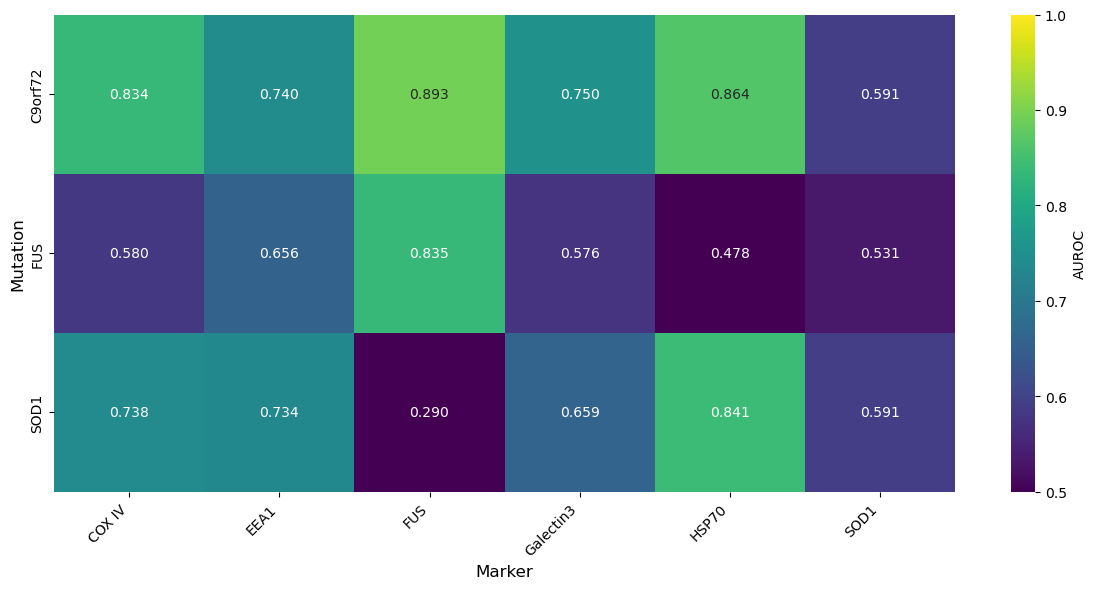

In [44]:
# Filter to cases where Mutation equals ModelGenetics
matching_auroc = auroc_with_markers[auroc_with_markers["Mutation"] == auroc_with_markers["ModelGenetics"]]

# Create pivot table for heatmap: rows = ModelGenetics, columns = Marker, values = AUROC
heatmap_data = matching_auroc.pivot_table(
    index="ModelGenetics", 
    columns="Marker", 
    values="AUROC",
    aggfunc="mean"  # In case there are duplicates
)

print("Heatmap data:")
print(heatmap_data)

# Plot heatmap
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt='.3f', 
    cmap='viridis', 
    vmin=0.5, 
    vmax=1.0,
    center=0.75,
    cbar_kws={'label': 'AUROC'},
    ax=ax
)

ax.set_xlabel('Marker', fontsize=12)
ax.set_ylabel('Mutation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [45]:
# Compute PPV and Recall at threshold 0.5
from sklearn.metrics import precision_score, recall_score, confusion_matrix

ppv_results = []
recall_results = []

for idx in grouped_predictions["ResultIndex"].unique():
    for model_gen in grouped_predictions["ModelGenetics"].unique():
        # Get predictions for this result index and model genetics
        subset = grouped_predictions[
            (grouped_predictions["ResultIndex"] == idx) & 
            (grouped_predictions["ModelGenetics"] == model_gen)
        ]
        
        # Get unique mutations (excluding WT)
        mutations = [m for m in subset["Mutations"].unique() if m != "WT"]
        
        for mutation in mutations:
            # Get data for this mutation vs WT
            mutation_data = subset[subset["Mutations"] == mutation]
            wt_data = subset[subset["Mutations"] == "WT"]
            
            # Check if we have both mutation and WT data
            if len(mutation_data) > 0 and len(wt_data) > 0:
                # Combine the data
                combined = pd.concat([mutation_data, wt_data])
                
                # Create binary labels (1 for mutation, 0 for WT)
                y_true = (combined["Mutations"] == mutation).astype(int)
                y_scores = combined["Class_1"]
                y_pred = (y_scores >= 0.5).astype(int)
                
                # Compute confusion matrix for fractions
                tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
                
                # Compute PPV and Recall
                try:
                    # PPV = TP / (TP + FP)
                    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
                    # Recall = TP / (TP + FN)
                    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
                    
                    ppv_results.append({
                        "Index": idx,
                        "ModelGenetics": model_gen,
                        "Mutation": mutation,
                        "PPV": ppv,
                        "TP": tp,
                        "FP": fp,
                        "Numerator": tp,
                        "Denominator": tp + fp
                    })
                    
                    recall_results.append({
                        "Index": idx,
                        "ModelGenetics": model_gen,
                        "Mutation": mutation,
                        "Recall": rec,
                        "TP": tp,
                        "FN": fn,
                        "Numerator": tp,
                        "Denominator": tp + fn
                    })
                except Exception as e:
                    print(f"Could not compute metrics for Index={idx}, ModelGenetics={model_gen}, Mutation={mutation}: {e}")

# Create results dataframes
ppv_df = pd.DataFrame(ppv_results)
recall_df = pd.DataFrame(recall_results)

print(f"PPV results shape: {ppv_df.shape}")
print(f"Recall results shape: {recall_df.shape}")

PPV results shape: (72, 8)
Recall results shape: (72, 8)


In [46]:
# Merge PPV and Recall with marker information
ppv_with_markers = ppv_df.merge(file_info_df, on="Index", how="left")
recall_with_markers = recall_df.merge(file_info_df, on="Index", how="left")

# Filter to cases where Mutation equals ModelGenetics
matching_ppv = ppv_with_markers[ppv_with_markers["Mutation"] == ppv_with_markers["ModelGenetics"]]
matching_recall = recall_with_markers[recall_with_markers["Mutation"] == recall_with_markers["ModelGenetics"]]

# Create pivot tables for heatmaps
ppv_heatmap_data = matching_ppv.pivot_table(
    index="ModelGenetics", 
    columns="Marker", 
    values="PPV",
    aggfunc="mean"
)

recall_heatmap_data = matching_recall.pivot_table(
    index="ModelGenetics", 
    columns="Marker", 
    values="Recall",
    aggfunc="mean"
)

# Create annotation arrays with fractions
ppv_annotations = matching_ppv.pivot_table(
    index="ModelGenetics",
    columns="Marker",
    values=["Numerator", "Denominator"],
    aggfunc="sum"
)

recall_annotations = matching_recall.pivot_table(
    index="ModelGenetics",
    columns="Marker",
    values=["Numerator", "Denominator"],
    aggfunc="sum"
)

# Create text annotations as fractions
ppv_annot = []
for row in ppv_heatmap_data.index:
    row_annots = []
    for col in ppv_heatmap_data.columns:
        num = int(ppv_annotations.loc[row, ("Numerator", col)])
        denom = int(ppv_annotations.loc[row, ("Denominator", col)])
        row_annots.append(f"{num}/{denom}")
    ppv_annot.append(row_annots)

recall_annot = []
for row in recall_heatmap_data.index:
    row_annots = []
    for col in recall_heatmap_data.columns:
        num = int(recall_annotations.loc[row, ("Numerator", col)])
        denom = int(recall_annotations.loc[row, ("Denominator", col)])
        row_annots.append(f"{num}/{denom}")
    recall_annot.append(row_annots)

print("PPV heatmap data:")
print(ppv_heatmap_data)
print("\nRecall heatmap data:")
print(recall_heatmap_data)

PPV heatmap data:
Marker           COX IV      EEA1       FUS  Galectin3     HSP70      SOD1
ModelGenetics                                                             
C9orf72        0.772727  0.789474  1.000000   0.800000  0.818182  0.750000
FUS            0.500000  0.615385  0.750000   0.500000  0.473684  0.562500
SOD1           0.846154  0.818182  0.384615   0.615385  0.833333  0.666667

Recall heatmap data:
Marker           COX IV      EEA1       FUS  Galectin3     HSP70      SOD1
ModelGenetics                                                             
C9orf72        0.772727  0.681818  0.681818   0.545455  0.818182  0.409091
FUS            0.500000  0.500000  0.750000   0.437500  0.562500  0.562500
SOD1           0.611111  0.500000  0.277778   0.444444  0.833333  0.444444


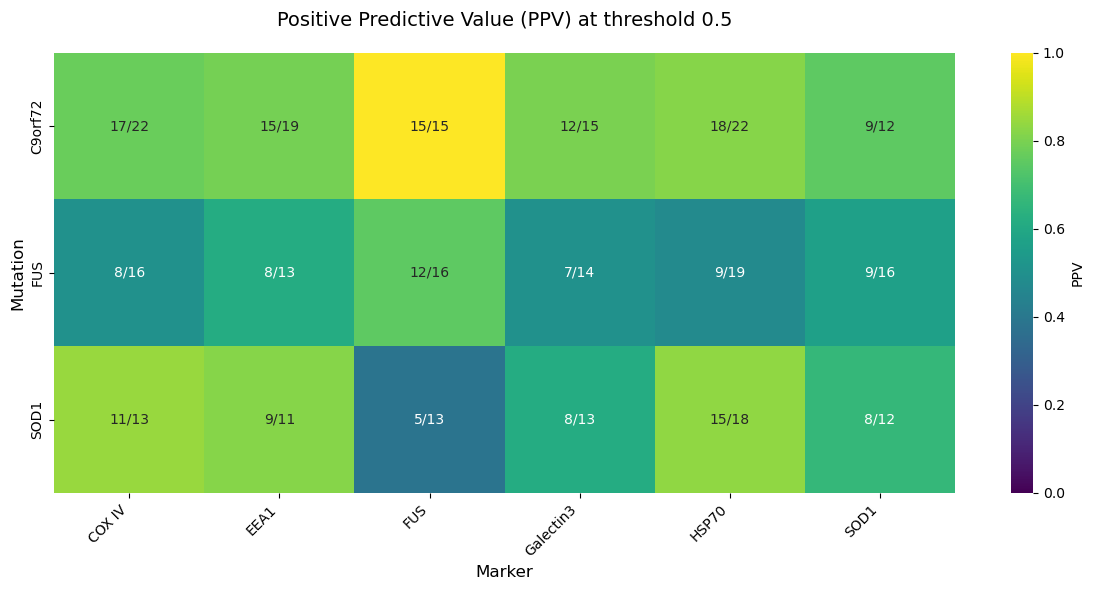

In [47]:
# Plot PPV heatmap
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    ppv_heatmap_data, 
    annot=ppv_annot,
    fmt='',
    cmap='viridis', 
    vmin=0.0, 
    vmax=1.0,
    cbar_kws={'label': 'PPV'},
    ax=ax
)

ax.set_title('Positive Predictive Value (PPV) at threshold 0.5', fontsize=14, pad=20)
ax.set_xlabel('Marker', fontsize=12)
ax.set_ylabel('Mutation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

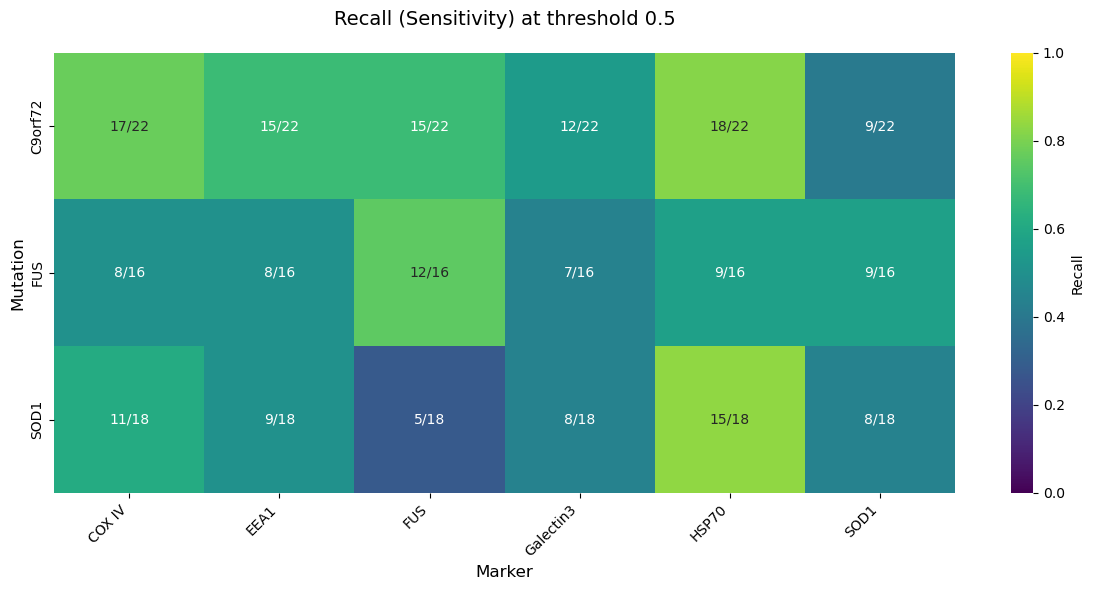

In [48]:
# Plot Recall heatmap
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    recall_heatmap_data, 
    annot=recall_annot,
    fmt='',
    cmap='viridis', 
    vmin=0.0, 
    vmax=1.0,
    cbar_kws={'label': 'Recall'},
    ax=ax
)

ax.set_title('Recall (Sensitivity) at threshold 0.5', fontsize=14, pad=20)
ax.set_xlabel('Marker', fontsize=12)
ax.set_ylabel('Mutation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [50]:
# Prepare data for barplots - merge grouped predictions with marker info
grouped_with_markers = grouped_predictions.merge(
    file_info_df[["Index", "Marker"]], 
    left_on="ResultIndex", 
    right_on="Index", 
    how="left"
)

# Get unique markers and mutations
unique_markers = grouped_with_markers["Marker"].unique()
unique_mutations = [m for m in grouped_with_markers["Mutations"].unique() if m != "WT"]

print(f"Markers: {unique_markers}")
print(f"Mutations: {unique_mutations}")

Markers: ['EEA1' 'FUS' 'COX IV' 'Galectin3' 'HSP70' 'SOD1']
Mutations: ['SOD1', 'C9orf72', 'FUS', 'sporadic']



Marker: EEA1


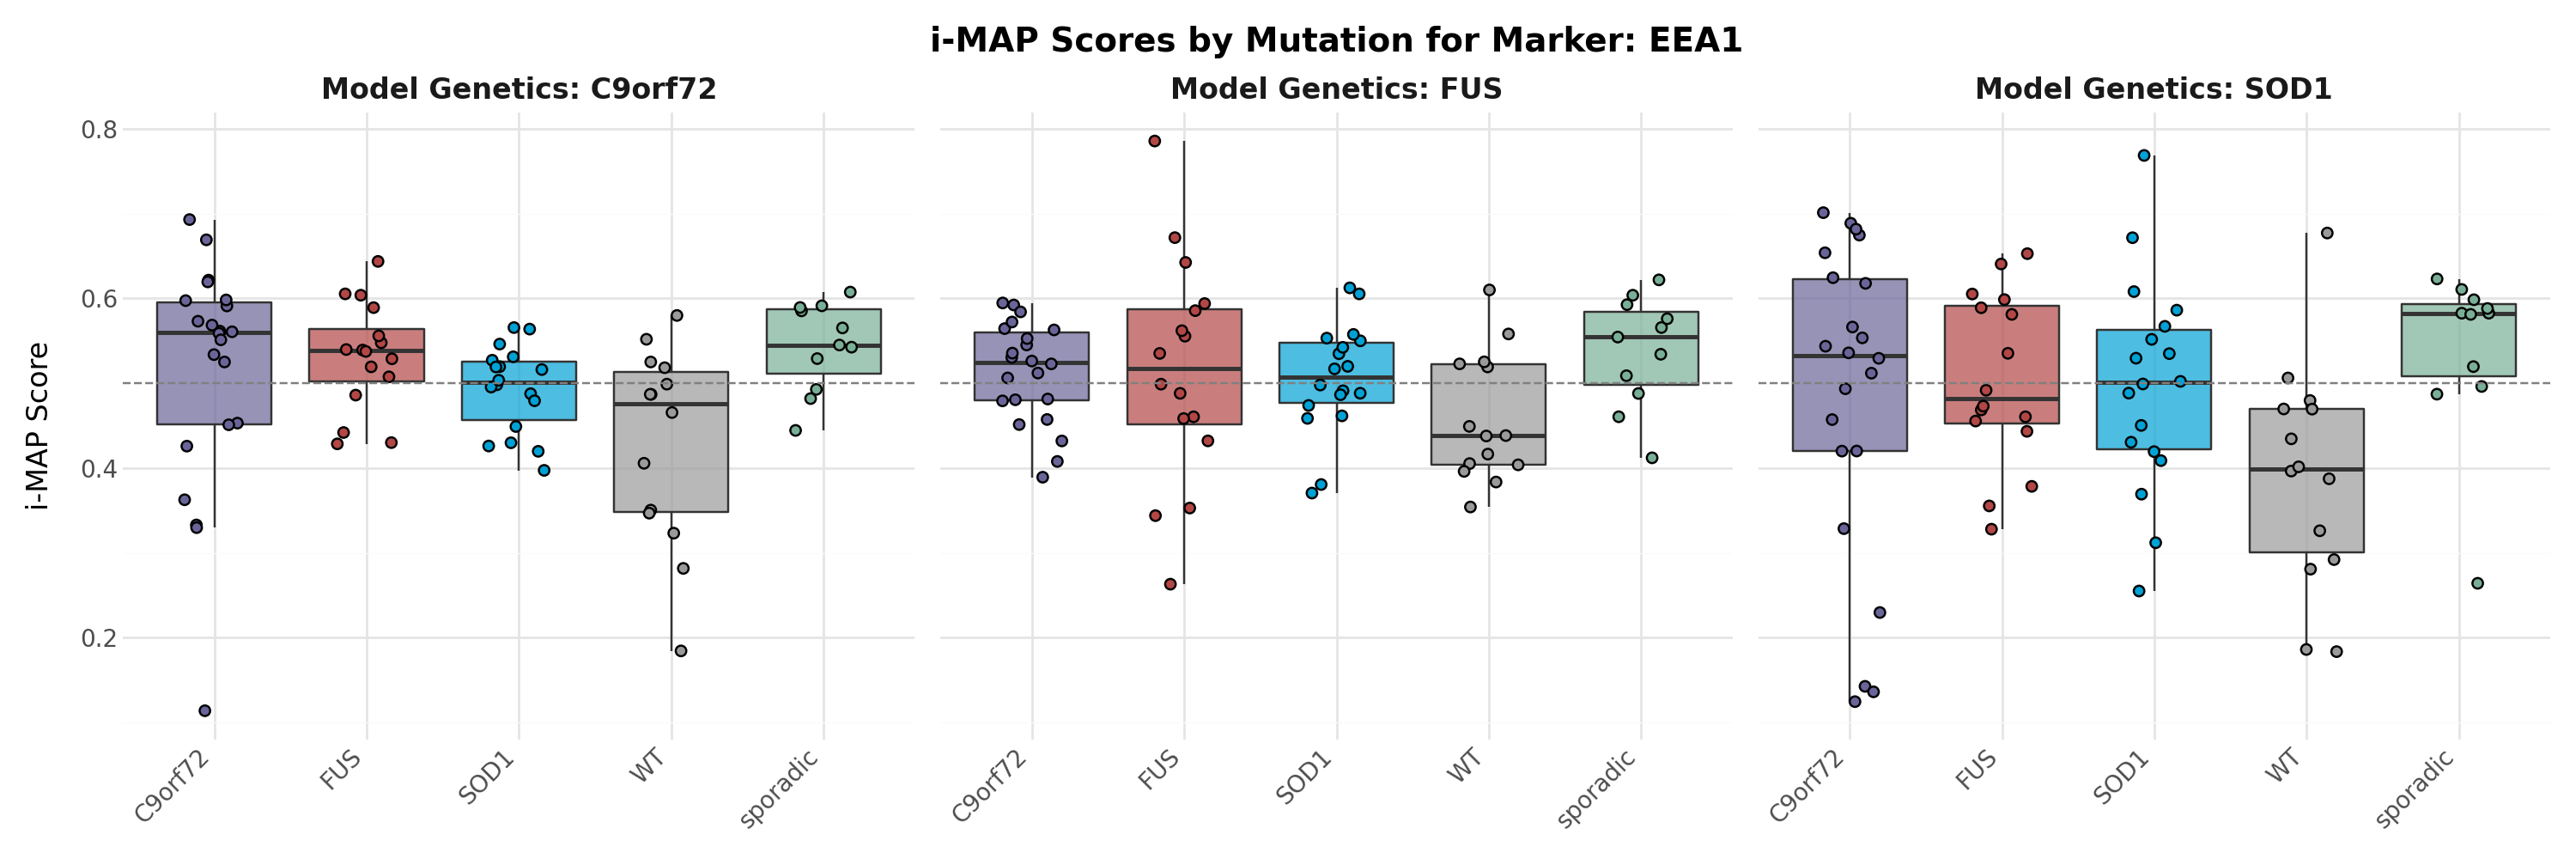


Marker: FUS


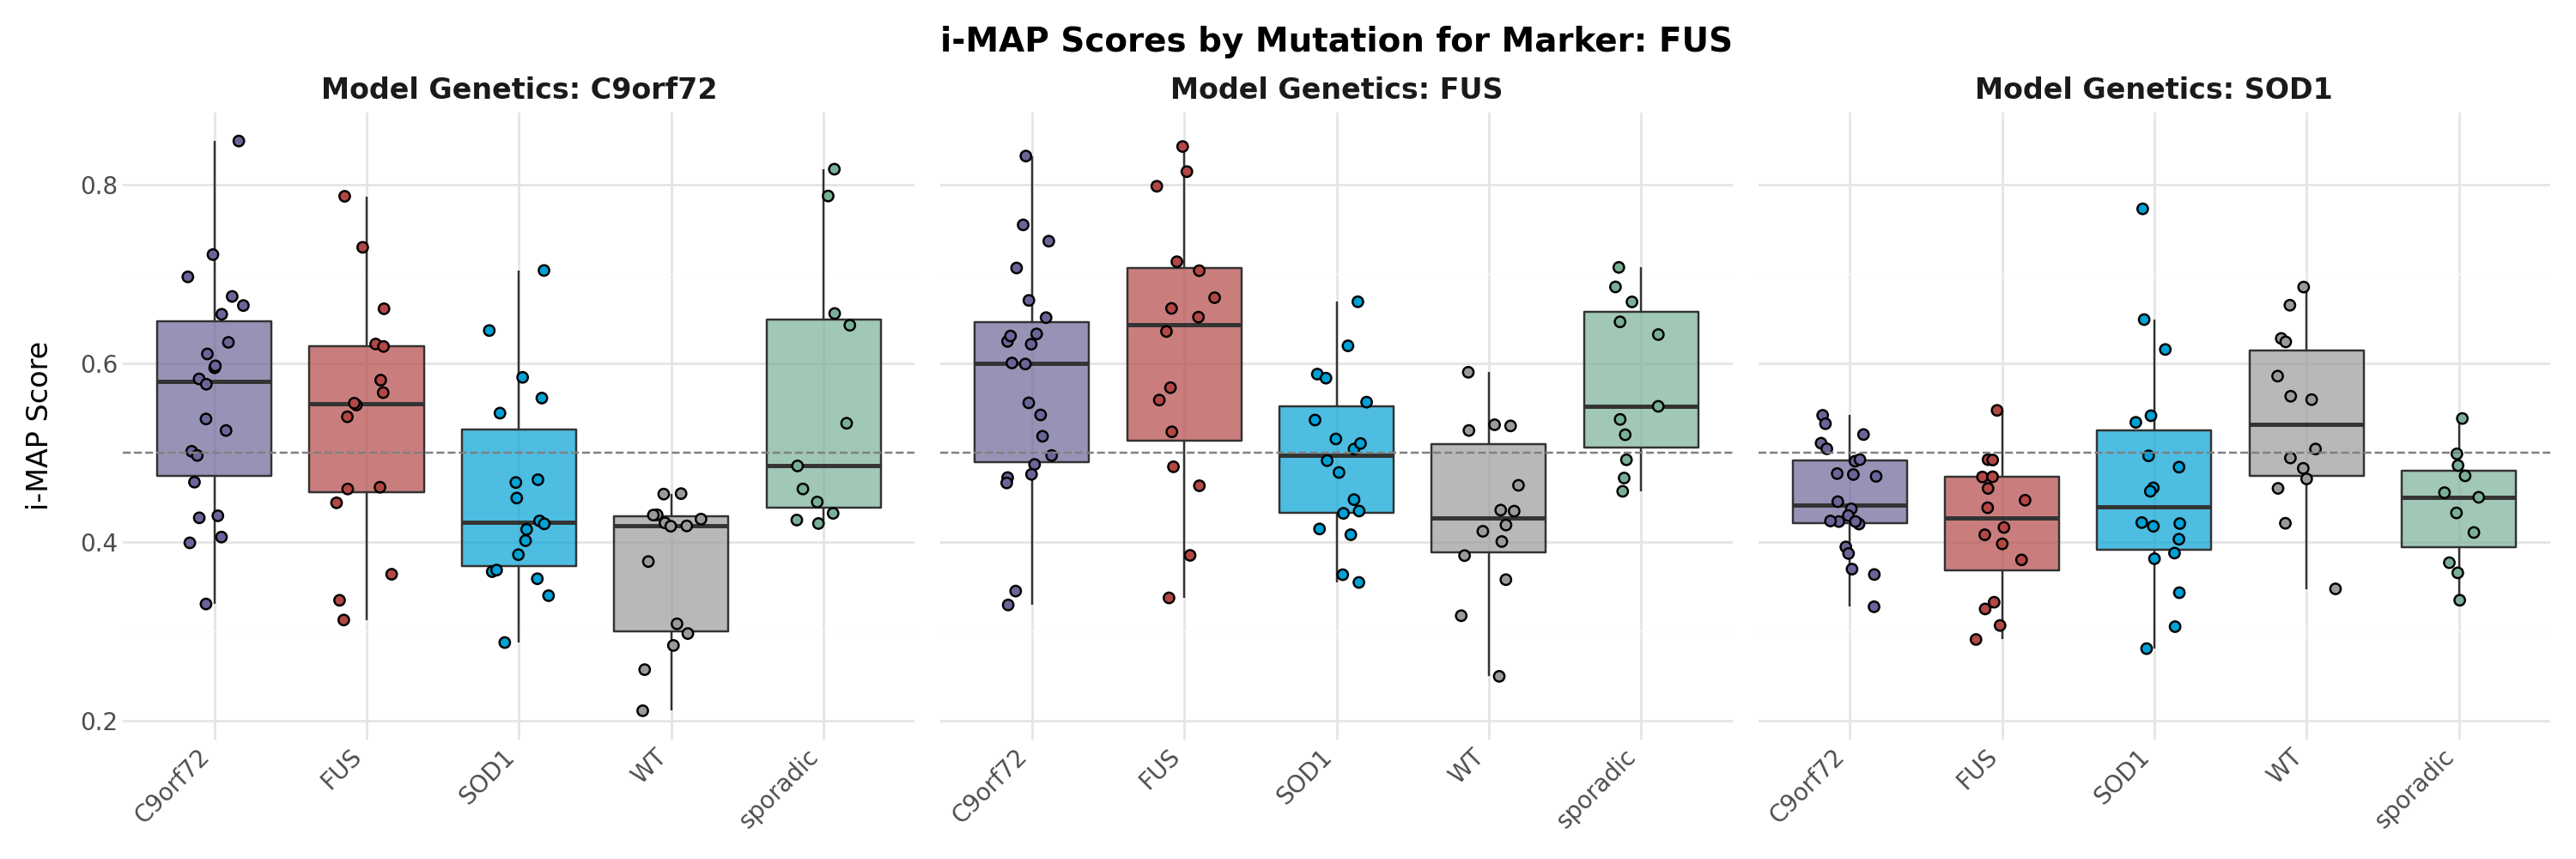


Marker: COX IV


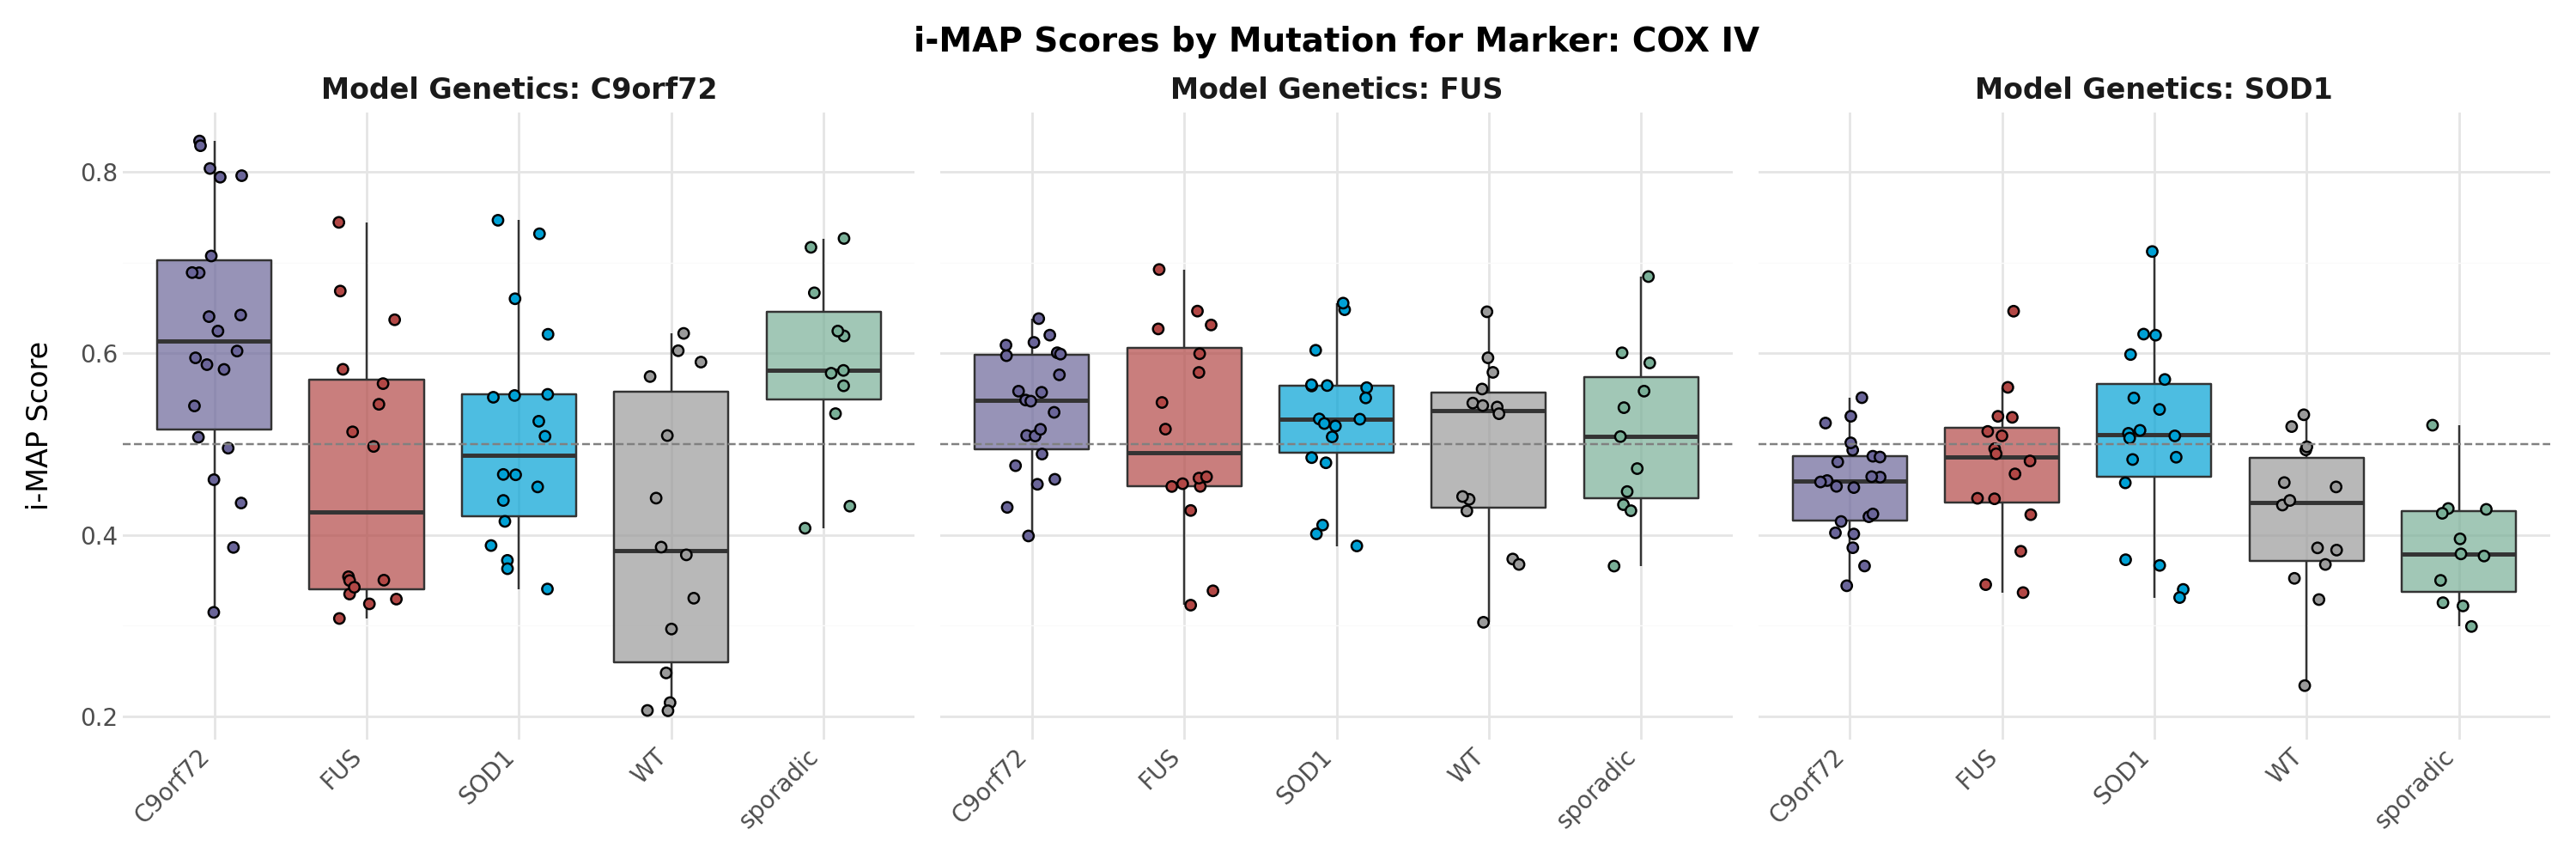


Marker: Galectin3


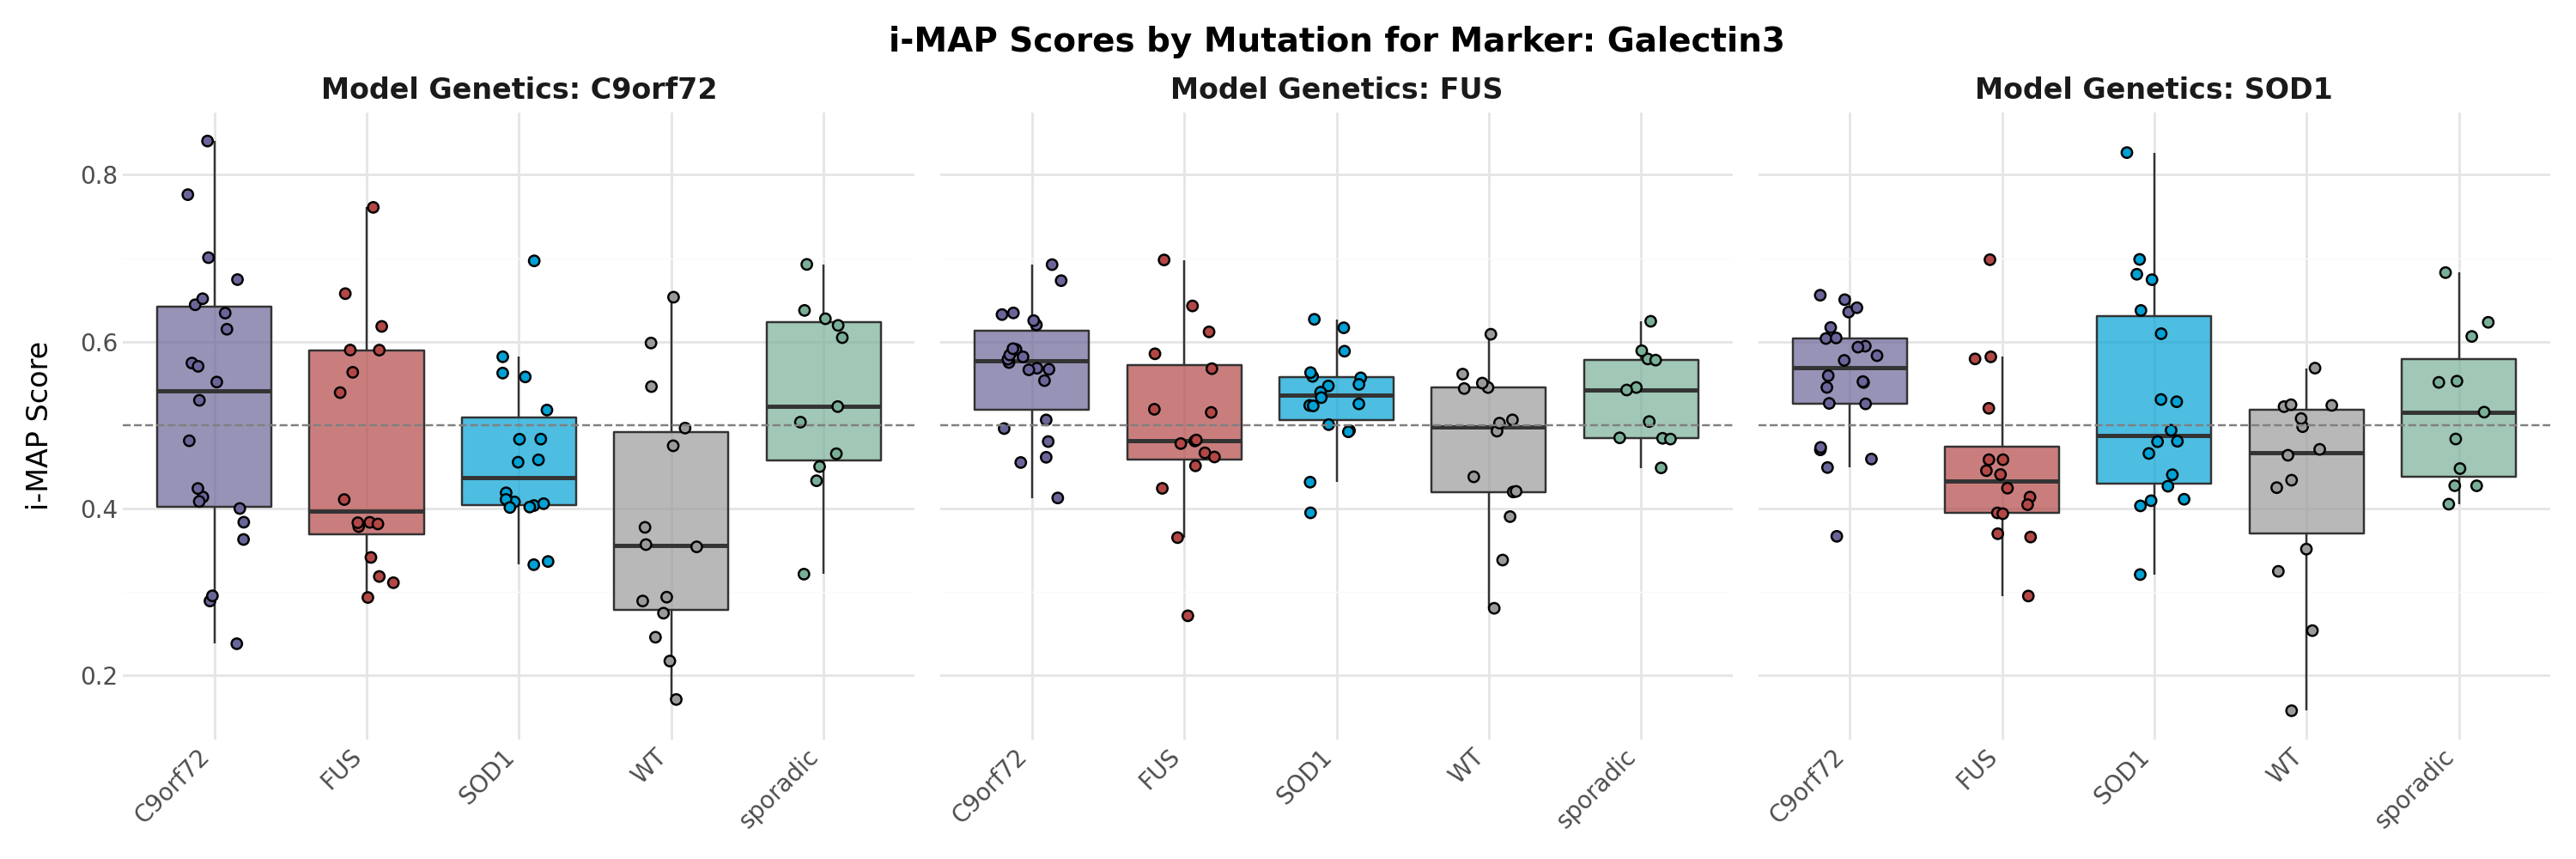


Marker: HSP70


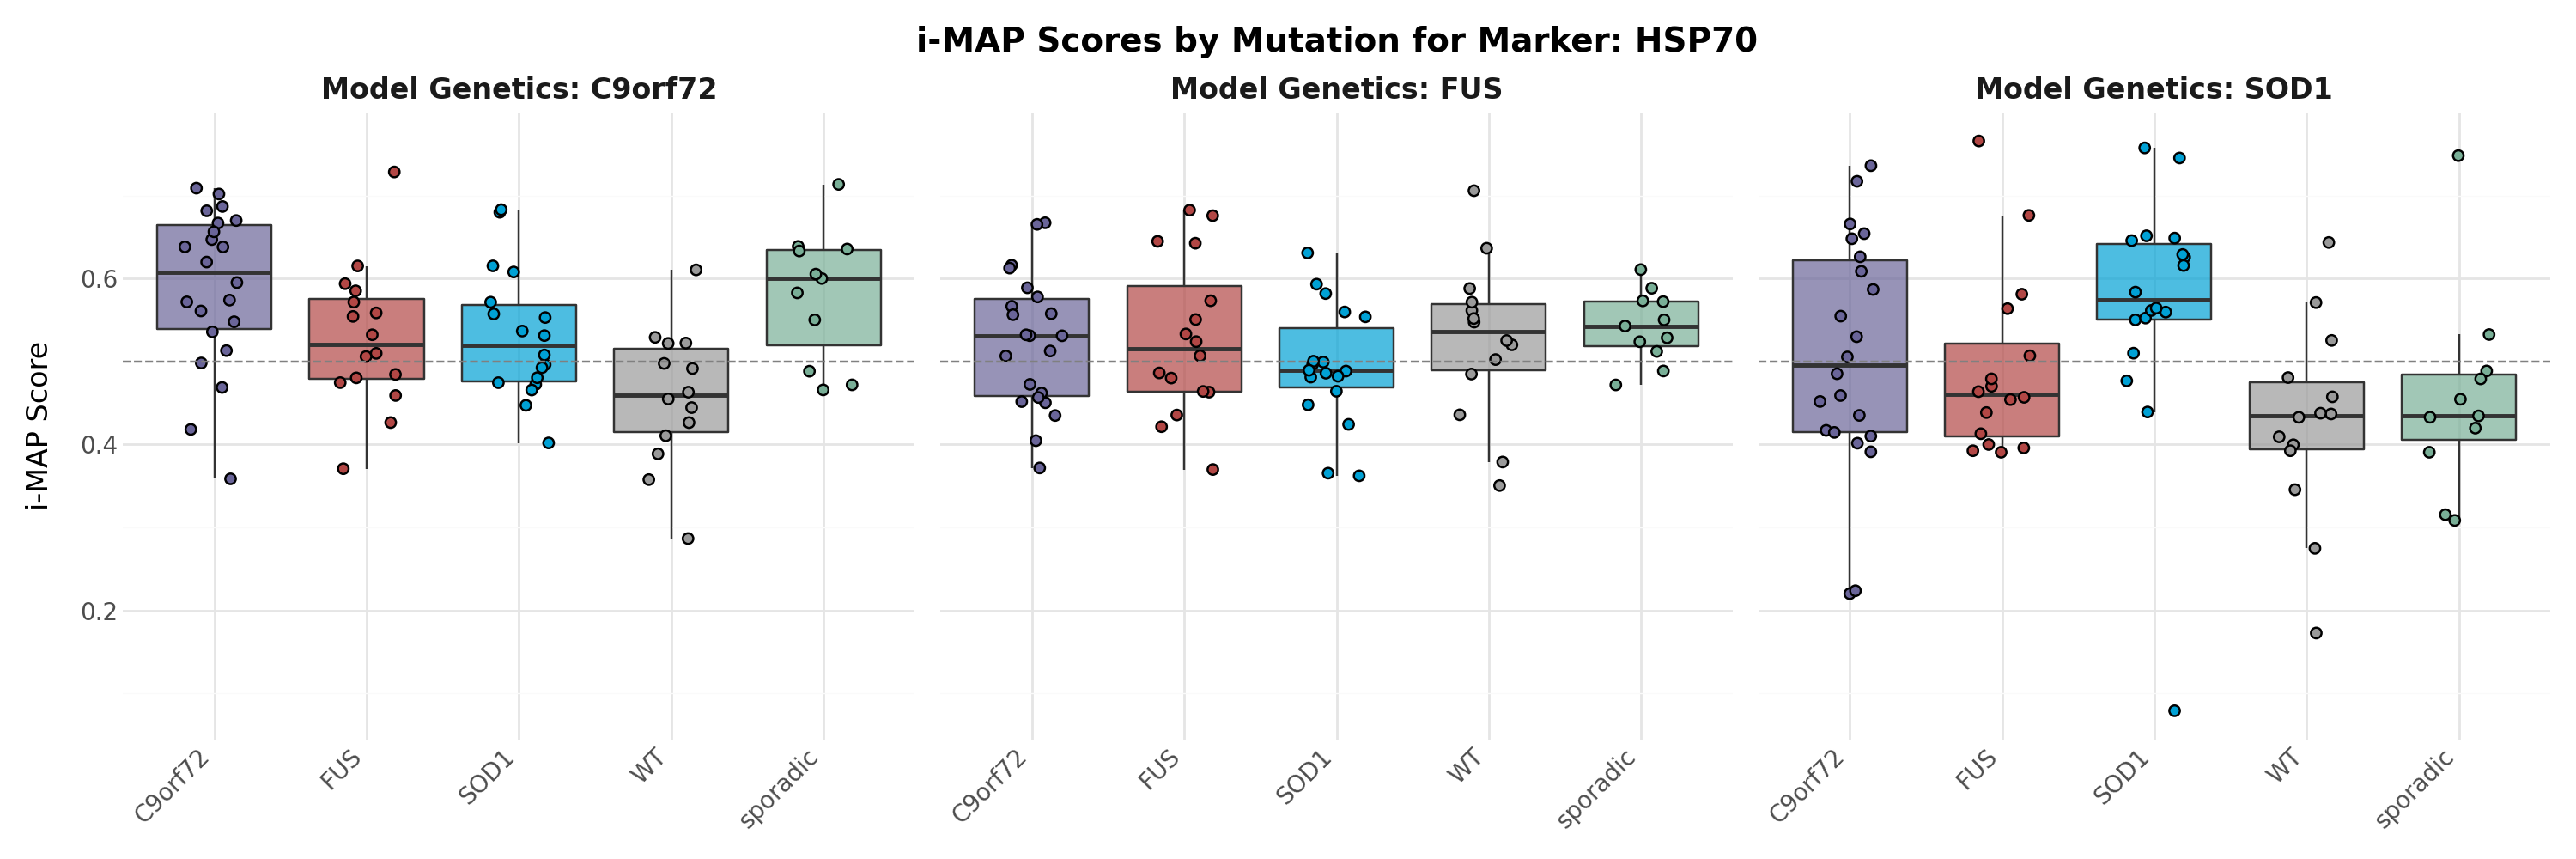


Marker: SOD1


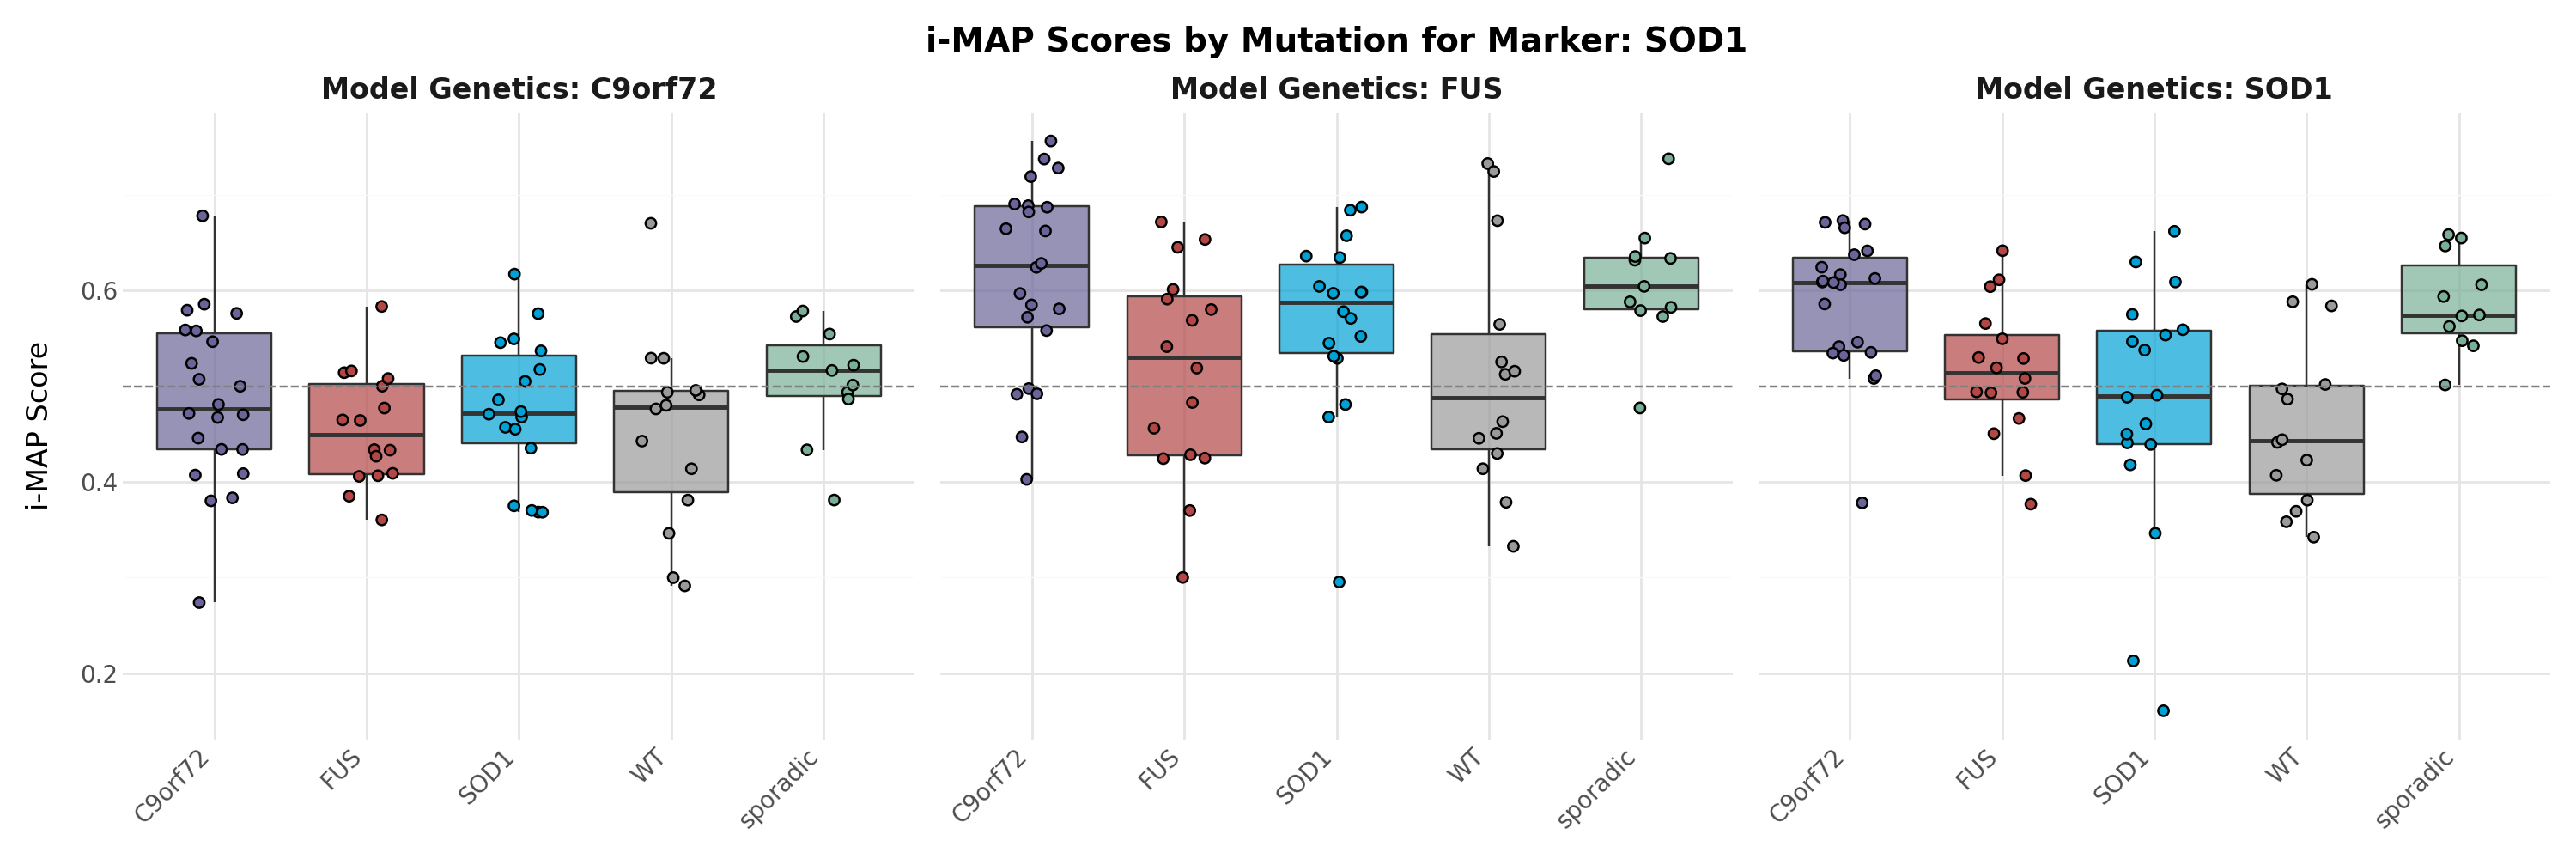

In [57]:
import plotnine as p9
from maps.figures import PALETTE

# Create barplots for each marker
for marker in unique_markers:
    # Filter data for this marker, and only include the three mutations + WT
    marker_data = grouped_with_markers[
        (grouped_with_markers["Marker"] == marker) & 
        (grouped_with_markers["Mutations"].isin(unique_mutations + ["WT"]))
    ].copy()
    
    # Filter to only include rows where ModelGenetics matches one of the three mutations
    marker_data = marker_data[marker_data["ModelGenetics"].isin(unique_mutations)].copy()
    
    # Create a facet variable based on ModelGenetics
    marker_data["Panel"] = marker_data["ModelGenetics"]
    
    # Rename Panel values for cleaner facet titles
    marker_data["Panel"] = marker_data["ModelGenetics"].apply(lambda x: f"Model Genetics: {x}")
    
    # Create the plot
    plot = (
        p9.ggplot(marker_data, p9.aes(x="Mutations", y="Class_1", fill="Mutations")) +
        p9.geom_boxplot(alpha=0.7, outlier_alpha=0) +  
        p9.geom_jitter(width=0.2, height=0, size=2) +
        p9.facet_wrap("~Panel", nrow=1) +
        p9.geom_hline(yintercept=0.5, color="grey", linetype="dashed") +
        p9.scale_fill_manual(values=PALETTE) +
        p9.labs(
            title=f"i-MAP Scores by Mutation for Marker: {marker}",
            x="",
            y="i-MAP Score",
            fill="Mutation"
        ) +
        p9.theme_minimal() +
        p9.theme(
            figure_size=(15, 5),
            axis_text_x=p9.element_text(angle=45, ha="right", size=10),
            axis_text_y=p9.element_text(size=10),
            axis_title=p9.element_text(size=12),
            plot_title=p9.element_text(size=14, face="bold"),
            strip_text=p9.element_text(size=12, face="bold"),
            legend_position="none"  # Remove legend
        )
    )
    
    print(f"\n{'='*60}")
    print(f"Marker: {marker}")
    print(f"{'='*60}")
    display(plot)